In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from darts import TimeSeries

df = pd.read_csv('../csv/Ming25Jun67_total_order.csv')
df.tail()

,order_completed_at,unique_order_count
536,2024-06-20,120
537,2024-06-21,152
538,2024-06-22,138
539,2024-06-23,126
540,2024-06-24,149


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_completed_at  541 non-null    object
 1   unique_order_count  541 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.6+ KB


In [4]:
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])

In [5]:
# make timeseries Object
series = TimeSeries.from_dataframe(df,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                    freq="D")

In [6]:
# Function to replace outliers with the mean of the rest of the values
from scipy.stats import zscore
from darts import TimeSeries

def replace_outliers_with_mean(df, column_name):
    # Calculate Z-scores
    z_scores = zscore(df[column_name])
    
    # Identify outliers (using a threshold of 3 for Z-score)
    outliers = np.abs(z_scores) > 3
    
    # Calculate mean of non-outliers
    mean_non_outliers = df.loc[~outliers, column_name].mean()
    
    # Replace outliers with the mean of non-outliers
    df.loc[outliers, column_name] = mean_non_outliers
    
    return df

# Replace outliers in 'gmv' column
df_remove_out = replace_outliers_with_mean(df, 'unique_order_count')
series_remove_outlier = TimeSeries.from_dataframe(df_remove_out,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                   freq="D")
series = series_remove_outlier # !!!

C:\Users\User\AppData\Local\Temp\ipykernel_13836\2557321846.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '142.47269303201506' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers, column_name] = mean_non_outliers


In [7]:
from darts.dataprocessing.transformers import (Scaler,)

scaler = Scaler()
series_rescaled = scaler.fit_transform(series)
series = series_rescaled

In [25]:
# training, validation =series.split_before(pd.Timestamp('2024-01-01'))
# training, validation =series.split_before(0.9)
cut_off = 0.8
training, validation =series.split_before(cut_off) # 1 month
# training, validation =series.split_before(pd.Timestamp('2024-04-01')) # 2 month

In [26]:
#check date split
validation_df = validation.pd_dataframe()
training_df = training.pd_dataframe()
print(training_df.tail())
print(validation_df.head())
print(training_df.shape)
print(validation_df.shape)

component           unique_order_count
order_completed_at                    
2024-03-03                    0.405759
2024-03-04                    0.150960
2024-03-05                    0.123037
2024-03-06                    0.171030
2024-03-07                    0.174520
component           unique_order_count
order_completed_at                    
2024-03-08                    0.157941
2024-03-09                    0.124782
2024-03-10                    0.140489
2024-03-11                    0.156195
2024-03-12                    0.162304
(432, 1)
(109, 1)


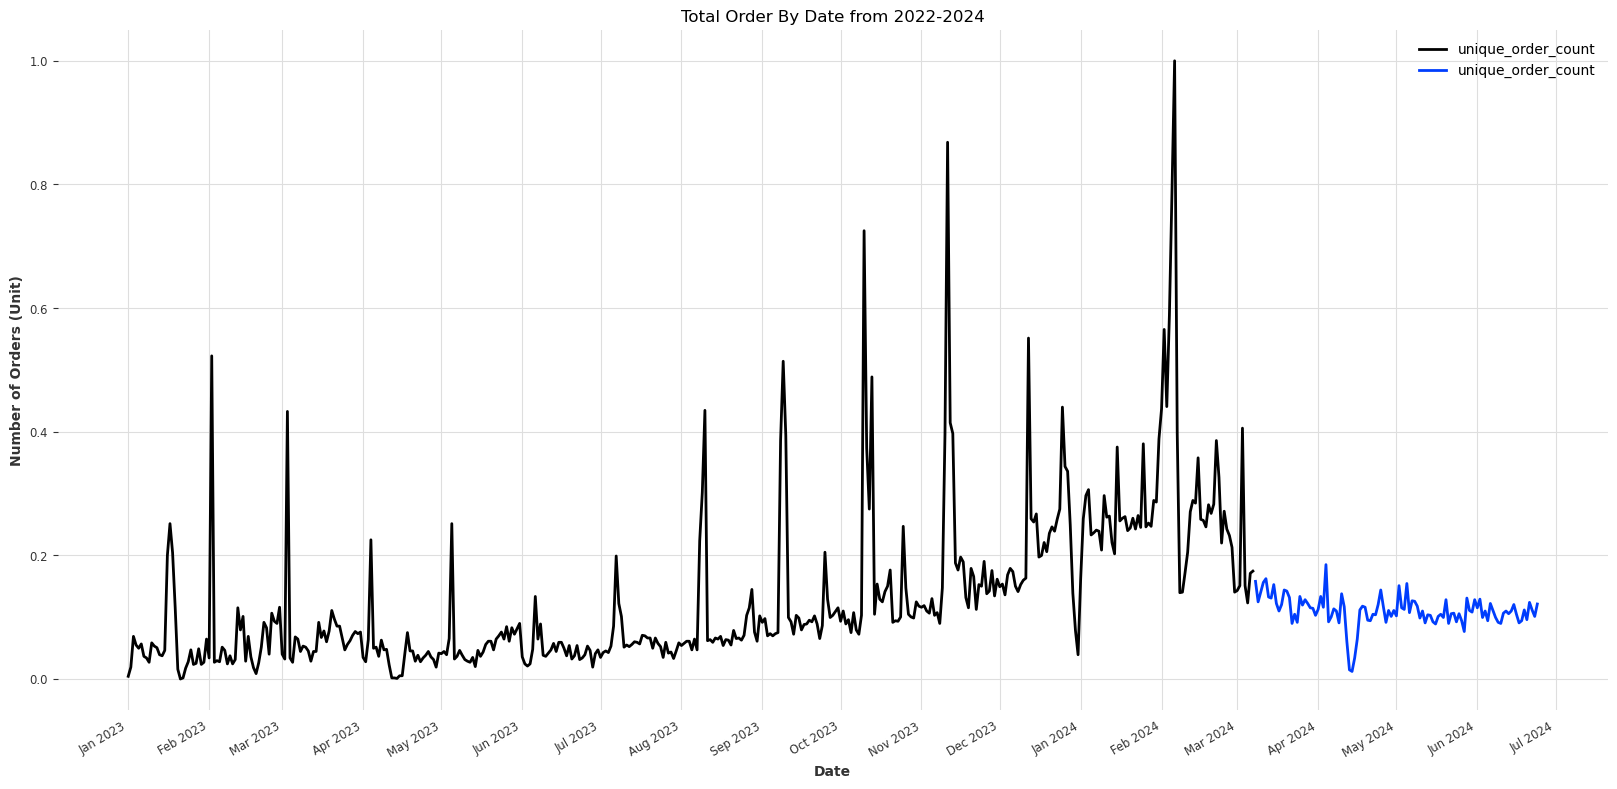

In [27]:
import matplotlib.dates as mdates

plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)
training.plot()
validation.plot()

# ตั้งค่ารูปแบบของวันที่บนแกน x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # ปรับให้วันที่ไม่ซ้อนกัน

# กำหนด Title และชื่อของแกน x และ y
plt.title('Total Order By Date from 2022-2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders (Unit)')

plt.show()

In [130]:
from darts.models import CatBoostModel

model = CatBoostModel(lags=42, output_chunk_length=7, random_state=42) # must at least input lags
model.fit(training)
forecast = model.predict(len(validation))

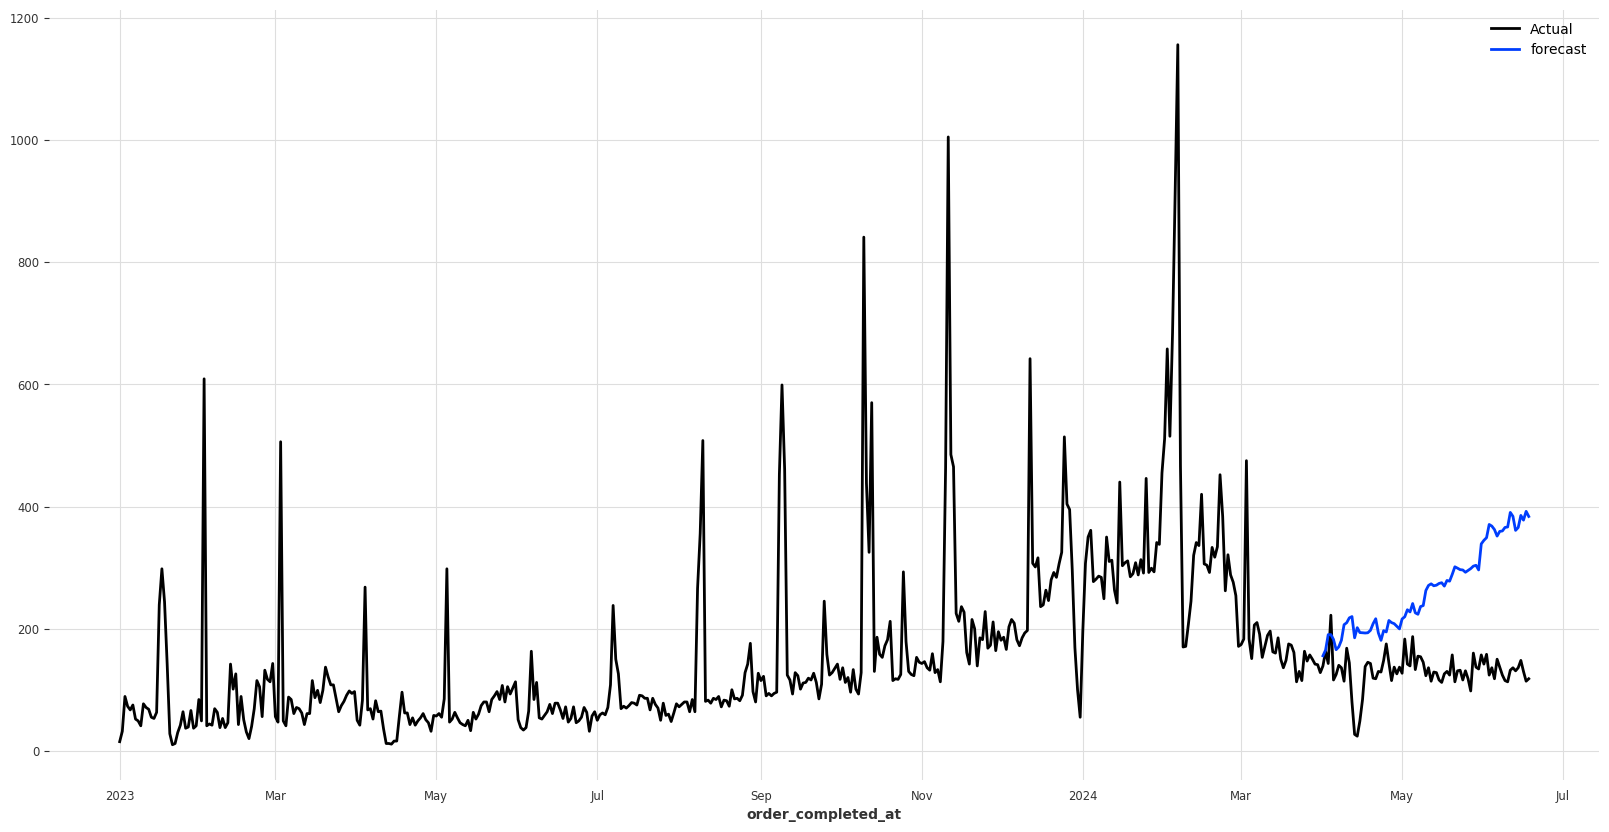

In [131]:
# plot Actual and Predict
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))  
series.plot(label="Actual")
forecast.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [132]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt
#not recommendation

mape_score = mape(validation, forecast)
print(f'score MAPE: {mape_score}')

mase_score = mase(validation, forecast, training)
print(f'score MASE: {mase_score}')

score MAPE: 121.01934201830733
score MASE: 2.7109064933587668


In [ ]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt

backtest_errors = model.backtest(
     series,
     start=pd.Timestamp("2024-04-01"),          # เริ่มต้นที่ 90% ของข้อมูล
     forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
     stride=7,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
     last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
     metric=mape,
     reduction=np.mean,           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
     verbose=-1
)
print(f'backtest_errors MAPE: {backtest_errors}')


In [28]:
from darts.models import CatBoostModel
from darts.metrics import mape, mae, mse, mase
from math import sqrt

parameters = {
    "lags":list(range(1,34)),
    "output_chunk_length":  [7],  # ทดลอง output_chunk_length ที่แตกต่างกัน
    "random_state": [42]
}

best_parameter = CatBoostModel.gridsearch(
    parameters=parameters,
    series = series, #note (training + validation) X only training set!!!
    start=cut_off,
    forecast_horizon=7,
    stride=7,          
    last_points_only=False,  
    metric=mse,
    reduction=np.mean, 
    verbose=-1 
)

  0%|          | 0/33 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

In [30]:
print(best_parameter)
# param_dict = best_parameter[1]
best_model = best_parameter[0]
best_model.fit(training)

(CatBoostModel(lags=7, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True), {'lags': 7, 'output_chunk_length': 7, 'random_state': 42}, 0.0035526860627858262)


CatBoostModel(lags=7, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True)

In [14]:
# best_model = best_parameter[0]
best_model = CatBoostModel(
    lags = 31,
    # n_estimators=100,
    # max_depth=9,
    output_chunk_length=7,
    random_state=42)
    # random_state=42)
best_model.fit(training)

CatBoostModel(lags=31, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True)

# test hyperparameter

In [ ]:
# from darts.models import CatBoostModel
# from darts.metrics import mape, mae, mse, mase
# from math import sqrt
# best_lags = 1
# best_mape = 100

# def find_mape_backtest(best_model):
#     backtest_errors = best_model.backtest(
#             series,
#             start=pd.Timestamp("2024-04-01"),          # เริ่มต้นที่ 90% ของข้อมูล
#             forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
#             stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
#             last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
#             metric=mape,
#             reduction=np.mean,           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
#             verbose=-1
#         )
#     return backtest_errors

# # best_model = best_parameter[0]
# for i in range(1,34):
#     best_model = CatBoostModel(
#         lags = i,
#         # n_estimators=100,
#         # max_depth=9,
#         output_chunk_length=7,
#         random_state=42)
#     best_model.fit(training)
#     mape_error = find_mape_backtest(best_model)
#     if i == 1: 
#         best_mape = mape_error
#     else:
#         if best_mape > mape_error:
#             best_lags = i; best_mape = mape_error

# print(f'best lags {best_lags} MAPE: {best_mape}')

In [ ]:
backtest_errors = best_model.backtest(
            series,
            start=pd.Timestamp("2024-05-01"),          # เริ่มต้นที่ 90% ของข้อมูล
            forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
            stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
            last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
            metric=mape,
            reduction=np.mean,           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
            verbose=-1
        )
print(f'backtest MAPE: {backtest_errors}')

In [31]:
# result from training , validation only
prediction = best_model.predict(len(validation))

mape_score = mape(validation, prediction)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation, prediction)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation, prediction)
print(f'score MAE: {round(mae_score, 4)}')

score MAPE: 200.1969
score ACC: -100.1969
score MSE: 0.0343
score RMSE: 0.1852
score MAE: 0.1687


In [32]:
validation_rescale = scaler.inverse_transform(validation)
prediction_rescale = scaler.inverse_transform(prediction)

mape_score = mape(validation_rescale, prediction_rescale)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation_rescale, prediction_rescale)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation_rescale, prediction_rescale)
print(f'score MAE: {round(mae_score, 4)}')

score MAPE: 170.8224
score ACC: -70.82239999999999
score MSE: 45044.5004
score RMSE: 212.2369
score MAE: 193.3696


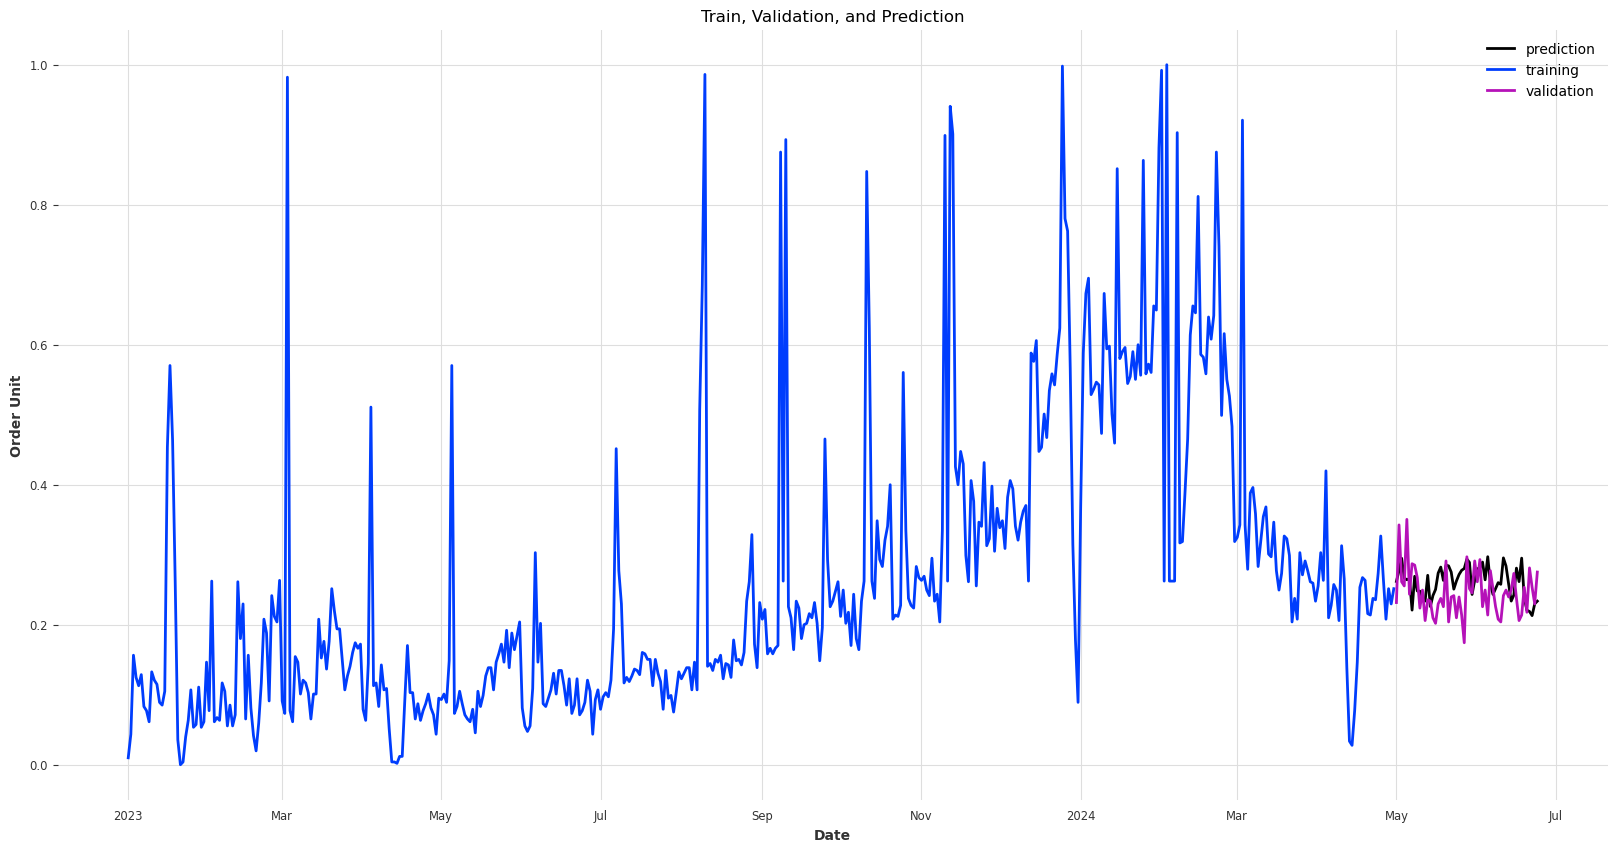

In [17]:
plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)
##prediction
prediction.plot(label="prediction")
training.plot(label="training")
validation.plot(label="validation")

plt.legend()
plt.title('Train, Validation, and Prediction')
plt.xlabel('Date')
plt.ylabel('Order Unit')
plt.show()

In [18]:
# predict future
best_model.fit(series)

CatBoostModel(lags=31, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True)

In [19]:
#check date
series.pd_dataframe().tail(14)

component,unique_order_count
order_completed_at,
2024-06-11,0.241584
2024-06-12,0.249505
2024-06-13,0.239604
2024-06-14,0.249505
2024-06-15,0.273267
2024-06-16,0.237624
2024-06-17,0.205941
2024-06-18,0.213861
2024-06-19,0.253465


In [20]:
forecast = best_model.predict(7)
forecast  = scaler.inverse_transform(forecast)
forecast = forecast.pd_dataframe().reset_index()
forecast.columns = ['Date', 'Total Order']
print(forecast.tail(7))

forecast.to_csv('../forecast/20-25-06-67_CatBoost_31lags.csv', index=False)

        Date  Total Order
0 2024-06-25   136.368804
1 2024-06-26   133.652766
2 2024-06-27   127.727396
3 2024-06-28   136.278871
4 2024-06-29   136.059137
5 2024-06-30   149.167831
6 2024-07-01   131.707477


In [21]:
#from darts.models import LinearRegressionModel, Prophet

best_model.save("../model/CatBoostModel_totalOrder_25Jun67_31lags.pkl")

In [7]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt
from darts.models import CatBoostModel

training, validation =series.split_before(pd.Timestamp('2024-05-01')) # 1 month

best_model = CatBoostModel.load("../model/CatBoostModel_totalOrder_25Jun67_31lags.pkl")
backtest_errors = best_model.backtest(
     series,
     start=pd.Timestamp('2024-05-01'),          # เริ่มต้นที่ 90% ของข้อมูล
     forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
     stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
     last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
     metric=mse,
     reduction=np.mean,           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
     verbose=-1
)
print(f'backtest_errors MSE: {backtest_errors}')

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/49 [00:00<?, ?it/s]

backtest_errors MSE: 378.29212506231835
